![Astrofisica Computacional](../../logo.png)

---
## FITS Images and WCS


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### About this notebook

In this notebook we visualize a FITS image using WCS.

---

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np

## 1. FITS Images and WCS

We will work with image data of the supernova remnant [Cassiopeia A](https://en.wikipedia.org/wiki/Cassiopeia_A), taken by the [Chandra X-ray observatory](http://chandra.harvard.edu/).

### 1.1 Reading the file


In [1]:
from astropy.io import fits

To open the fits file we use `fits.open()` and just specify the filename as an argument:

In [3]:
hdulist = fits.open('data/casa_0.5-1.5keV.fits.gz')

We can retrieve some basic information on the  header data unit (HDU) by calling `.info()`:

In [4]:
hdulist.info()

Filename: data/casa_0.5-1.5keV.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (1024, 1024)   float32   


It contains only one `PrimaryHDU` with data dimensions `(1024, 1024)` of format `float32`. To access the hdu we use:

In [5]:
image_hdu = hdulist['PRIMARY'] 

#or

image_hdu = hdulist[0] 

We can access the data with the `.data` attribute:

In [6]:
image_hdu.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

It is a plain 2d numpy array. We use `plt.imshow()` to visualize it:

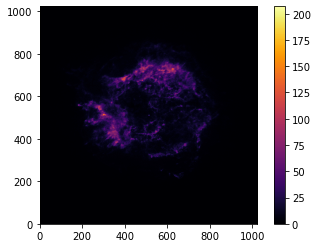

In [8]:
plt.imshow(image_hdu.data, origin='lower', cmap='inferno')
plt.colorbar();

Additional meta information is stored in the `.header` attribute:

In [9]:
image_hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Axis Length                                    
NAXIS2  =                 1024 / Axis Length                                    
OBJECT  = 'Cassiopeia A'                                                        
DATE-OBS= '2007-12-05T22:01:59'                                                 
DATE-END= '2007-12-08T20:07:24'                                                 
LTM1_1  =                    1                                                  
LTM1_2  =                    0                                                  
LTM2_1  =                    0                                                  
LTM2_2  =                    1                                                  
LTV1    =                -36

### 1.2 World Coordinate System

The FITS standard defines the world coordinate system (WCS) as a mechanism to associate physical values to positions within a dataset. For example, it can be used to convert pixel coordinates in an image to celestial coordinates like the right ascension and declination. 

The header information can be used to create a world coordinate to pixel coordinate transformation, using the [astropy.wcs.WCS](http://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS) class:

In [11]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [12]:
wcs = WCS(image_hdu.header)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 350.8841248  58.78133011  
CRPIX : 445.5  289.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001366666693  0.0001366666693  
NAXIS : 1024  1024


Using the helper methods [SkyCoord.to_pixel()](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.to_pixel) and [SkyCood.from_pixel()](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.from_pixel) we can now convert every position in the image to the corresponding sky coordinate:

In [13]:
SkyCoord.from_pixel(0, 0, wcs)

<SkyCoord (ICRS): (ra, dec) in deg
    (351.00119731, 58.74184873)>

In [16]:
#position_casa = SkyCoord('23h23m27.94s', '+58d48m42.4s', frame='icrs')

# or

position_casa = SkyCoord.from_name('Cas A')

position_casa.to_pixel(wcs)

(array(573.79215824), array(534.89801134))

## 2. Plotting of sky images

Astropy provides a helper module [astropy.visualization.wcsaxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/) to simplify plotting of sky images with Matplotlib.

To use it we just pass `projection=wcs` to the `plt.subplot()` function:

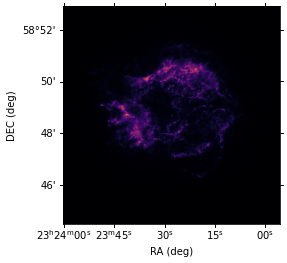

In [17]:
ax = plt.subplot(projection=wcs)
ax.imshow(image_hdu.data, cmap='inferno', origin='lower')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

And we get the plot with the x-axis and y-axis in sky coordinates. 

We can add a coordinate grid with `ax.grid()`:

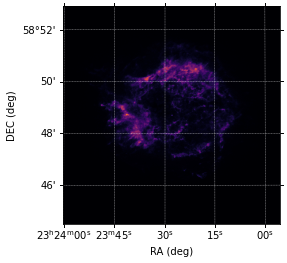

In [18]:
ax.grid(linewidth=0.3, linestyle='dashed', color='white')
ax.figure

We add a white cross to mark the center position of `'Cas A'`:

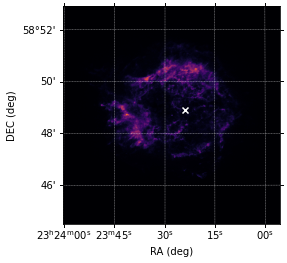

In [19]:
ra = position_casa.icrs.ra.deg
dec = position_casa.icrs.dec.deg
ax.scatter(ra, dec, transform=ax.get_transform('icrs'), color='white', marker='x')
ax.figure

We can also add geometrical shapes to the image to illustrate regions:

In [20]:
from matplotlib.patches import Circle
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u

In [23]:
# transform to pixel coordinates
xy = ax.wcs.world_to_pixel(position_casa)
pixel_size = proj_plane_pixel_scales(wcs)[0] * u.deg
radius = 2.3 * u.arcmin / pixel_size

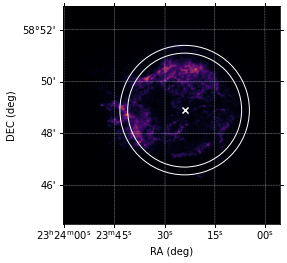

In [24]:
circle = Circle(
    xy=xy,
    radius=radius.to_value(""),
    edgecolor="w",
    facecolor="None"
)
ax.add_patch(circle)
ax.figure

For plotting more complex shapes and handling of regions in general incl. plotting there is an Astropoy affiliated package named [regions](https://astropy-regions.readthedocs.io/en/stable/).